In [1]:
## Scikit learn libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

## For NLP
from bs4 import BeautifulSoup, Tag    ## Cleaning HTML tags from text
import nltk, string
from nltk.corpus import stopwords 
import re

## Glove vectors
from tqdm import tqdm                 ## Progress bar for loading GloVe embeddings
from nltk import word_tokenize        ## For GloVe

## Common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data I/O
import json     ## To convert json raw data to df
import pickle   ## saving the model to disk

import xgboost as xgb
from scipy.stats import uniform, randint

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

## Problem texts can be long and may not load on Jupyter
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


## Extract subject wise training data

In [2]:
# Load the dataset and show sample question
with open('../data/qs_topicwise.json') as json_data:
    all_questions = json.load(json_data)

subject_model = ['CHM']

## Create empty df 
data_df = pd.DataFrame(columns=['code', 'curriculum', 'subject', 'grade', 'question_text', 'chapter'])

## Removing these words improves Phy clf accuracy by 2% but improves Math classifier accuracy
words_to_remove = ["rightarrow", "hence", "frac", "text", "sqrt", "times", 
                   "value", "amp", "statement", "will", "equal", "number", 
                   "tan", "now", "can", "two", "get", "true", "lambda", "a", "an", "the"]
stop_words = stopwords.words('english')         ## Downloaded from NLTK
'''
for PHY - removing Stopwords reduce acc & f1 score : 67% -> 63%, 74% -> 72%
for CHM - removing Stopwords reduce acc & f1 score by 6%
for MTH - 
'''

## Remove dummy and empty chapters
chapters_to_remove = ['Selection Test', 'Repository', 'Bridge Intervention Curriculum', 
                      'M1.1 Scaffold test', 'Tally Marks', 'Dummy']
chapters_with_no_data = ['Static Electricity', 'Experimental Skills', 'Nuclear Chemistry', 
                         'Principle of Mathematical Induction', 'Environmental Chemistry']

## Regex pattern for alpha numeric - Improves accuracy & f1-score for Phy by 2%
pattern = re.compile('[\W_]+')

i = 0
for question in all_questions:
    try: 
        question_text = question['question_text'].lower()
        ## Remove HTML tags from text using Beautiful Soup
        '''
        For MTH, it improves accuracy from 40% to 60% in MTH, 
        For PHY, it reduces accuracy from 60% to 20%. 
        For CHM, it increases accuracy from 50% to 52% 
        '''
        question_text = BeautifulSoup(question_text, "html.parser").get_text() 
        ## Remove numbers
        '''
        For PHY, removing nos improved accuracy & F1 score by 0.5%
        For CHM, removing nos improved acc by 2%
        '''
        question_text = ''.join(c for c in question_text if not c.isdigit())
        ## Regex pattern for alpha numeric text
        '''
        For CHM, removing this regex improved score by 9%
        '''
        question_text = pattern.sub(" ", question_text)
        ## Remove stop words
        '''
        For CHM, keeping both sets of words, instead of removing them improved acc by 5%
        '''
        #question_text = " ".join([word for word in question_text.split() if word not in words_to_remove])
        #question_text = " ".join([word for word in question_text.split() if word not in stop_words])
        ## Remove extra whitespaces
        question_text = " ".join(question_text.split()) 
        ## Extracting elements for cleaner code
        grade = question['grade']
        curriculum = question['curriculum']
        chapter = question['chapter']
        subject = question['subject']
        ## Filtering each question from JSON to add relevant Qs to dataframe 
        if(    "JEE" in curriculum and grade in ["11", "12"] and
               chapter not in chapters_to_remove and
               chapter not in chapters_with_no_data and
               "dummy" not in question_text and subject in subject_model):
                data_df.loc[i] = [question['problem_code'],curriculum, subject, \
                                  grade, question_text, chapter]
                i += 1
    except:
            pass

trainDF = pd.DataFrame(columns=['text', 'label'])
trainDF['text'] = data_df['question_text']
trainDF['label'] = data_df['chapter']
trainDF.head(3)

,text,label
0,which of the following statements is incorrect,Solutions
1,dry air was successively passed through a solution of g solute in g water and through pure water the loss in weight of solution was g and that of pure water was g molecular weight of solute in g mol is m find the value of frac m assume that solute is non volatile and does not dissociate or associate,Solutions
2,an aqueous solution boils at k what is the freezing point of the same solution given k f circ c m and k b circ c m,Solutions


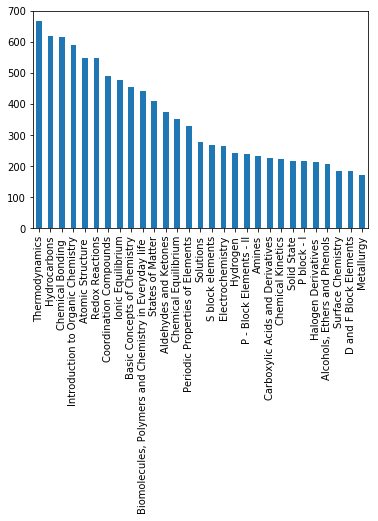

In [3]:
trainDF.label.value_counts().plot(kind="bar")

## Train test split

In [4]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.2)
print(len(train_x), len(valid_x) )

8220 2055


## Create pipeline for vectorizer & classifier

#### Label Encoding
Label encoding is not needed for sklearn classifiers, as they are all capable of mutli-class classification, and handle label encoding automatically. Source :  https://stackoverflow.com/questions/51525043/encoding-labels-for-multi-class-problems-in-sckit-learn

For non-sklearn models like NNs or XGB, we need to do label encoding

In [5]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_y)
train_y = encoder.transform(train_y)
valid_y = encoder.transform(valid_y)
valid_y[0:5]

array([28, 19,  3,  1, 10])

### Glove vectors
Loading GloVe embeddings from Standford dataset : http://www-nlp.stanford.edu/data/glove.840B.300d.zip


In [6]:
## Source - https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle
# load the GloVe vectors in a dictionary:
# create a map of words to vectors

embeddings_index = {}
f = open('glove.840B.300d.txt', 'r', encoding='utf8', errors = 'ignore')

for line in tqdm(f):     ## tqdm adds a progress bar
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:31, 10373.10it/s]

Found 2195892 word vectors.


In [7]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [8]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_x)]
xvalid_glove = [sent2vec(x) for x in tqdm(valid_x)]

100%|██████████| 2055/2055 [00:00<00:00, 2288.94it/s]


In [9]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

### Trying xgboost on GloVe features

In [10]:
%time
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=4, silent=False)
clf.fit(xtrain_glove, train_y)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 30 µs


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1, verbosity=1)

In [11]:
pred_y = clf.predict(xvalid_glove)

print("accuracy: {:0.3f}".format(metrics.accuracy_score(valid_y, pred_y)))
print("F1-score (weighted): {:0.3f}".format(metrics.f1_score(valid_y, pred_y, average = 'weighted')))

accuracy: 0.564
F1-score (weighted): 0.547


In [12]:
report = metrics.classification_report(valid_y, pred_y)
print(report)

              precision    recall  f1-score   support

           0       0.25      0.07      0.11        42
           1       0.38      0.38      0.38        80
           2       0.48      0.32      0.38        41
           3       0.69      0.78      0.73       101
           4       0.54      0.55      0.54        95
           5       0.70      0.70      0.70        91
           6       0.29      0.12      0.17        49
           7       0.53      0.73      0.62       137
           8       0.77      0.74      0.75        66
           9       0.71      0.60      0.65        50
          10       0.61      0.63      0.62       110
          11       1.00      0.06      0.12        32
          12       0.78      0.66      0.71        47
          13       0.33      0.12      0.17        43
          14       0.38      0.60      0.46       119
          15       0.48      0.33      0.39        45
          16       0.37      0.52      0.43       104
          17       0.65    

In [13]:
%time
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=100, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, train_y)
pred_y = clf.predict(xvalid_glove)

print("accuracy: {:0.3f}".format(metrics.accuracy_score(valid_y, pred_y)))
print("F1-score (weighted): {:0.3f}".format(metrics.f1_score(valid_y, pred_y, average = 'weighted')))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 21 µs
accuracy: 0.606
F1-score (weighted): 0.592


### Confusion Matrix

In [14]:
metrics.confusion_matrix(valid_y, pred_y)

array([[  5,   5,   1,   0,   0,   2,   3,   3,   0,   0,   1,   0,   0,
          3,  11,   0,   6,   0,   0,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  4,  34,   0,   0,   0,   0,   5,   0,   0,   0,   1,   0,   0,
          2,  22,   0,   5,   1,   0,   1,   0,   0,   4,   0,   0,   0,
          0,   0,   1],
       [  2,   3,  13,   0,   0,   0,   3,   0,   0,   0,   0,   1,   0,
          0,  11,   0,   5,   1,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,  84,   0,   0,   0,   7,   0,   0,   3,   0,   0,
          0,   1,   0,   0,   0,   0,   0,   0,   2,   2,   0,   1,   0,
          0,   0,   1],
       [  0,   0,   0,   4,  59,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   3,   0,   1,   4,   1,   3,   0,   2,   5,   1,   0,   4,
          3,   2,   2],
       [  0,   0,   0,   2,   2,  67,   1,   3,   0,   0,   1,   0,   0,
          1,   2,   0,   6,   1,   0,   0,   2,   1,   1,   0,   0,   1,
    

#### Chapters that were never predicted

In [15]:
set(valid_y) - set(pred_y)

set()